In [1]:
import numpy as np
import pandas as pd
import toad
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from toad.plot import bin_plot
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
import xgboost
from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression 

from sklearn.metrics import accuracy_score, f1_score,precision_score, recall_score

In [2]:
parse_dates = ['CreatedDate', 'RequestedDate', 'AccTime', 'PupTime', 'DelTime']
data = pd.read_csv('Booking_Dispatch_training_set.csv', parse_dates = parse_dates, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))
#read training dataset

In [3]:
parse_dates2 = ['CreatedDate', 'RequestedDate']

validation = pd.read_csv('Booking_Dispatch_validation_set.csv', parse_dates = parse_dates2, \
                   date_parser = lambda x: pd.to_datetime(x).strftime("%Y-%m-%d %H:%M:%S"))
#read validation dataset

In [4]:
data.shape
#checking training dataset shape

(3000000, 37)

In [5]:
validation.shape
#checking validation dataset shape

(300000, 17)

In [6]:
data['TargetVariable'].value_counts()/len(data)
#checking target variable proportion

Completed    0.776306
Cancelled    0.128554
No Job       0.082690
ELSE         0.012449
Name: TargetVariable, dtype: float64

In [7]:
# binary target: 'Cancelled'
target_dict = {'Cancelled':1,'Completed':0,'ELSE':0,'No Job':0,}
data['target_2cls_Cancelled'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Cancelled'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'Completed'
target_dict = {'Cancelled':0,'Completed':1,'ELSE':0,'No Job':0,}
data['target_2cls_Completed'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_Completed'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'ELSE'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':1,'No Job':0,}
data['target_2cls_ELSE'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_ELSE'] = validation['TargetVariable'].replace(target_dict)

# binary target: 'No Job'
target_dict = {'Cancelled':0,'Completed':0,'ELSE':0,'No Job':1,}
data['target_2cls_NoJob'] = data['TargetVariable'].replace(target_dict)
validation['target_2cls_NoJob'] = validation['TargetVariable'].replace(target_dict)
#create binary target for feature engineering

In [8]:
target_dict2 = {
    'Cancelled':0,
    'Completed':1,
    'No Job':2,
    'ELSE':3,
}

data['target_4cls'] = data['TargetVariable'].replace(target_dict2)
validation['target_4cls'] = validation['TargetVariable'].replace(target_dict2)
#create multi class target for modelling

In [9]:
validation.columns
#check validation variables

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'FinalDispatchStatus', 'TargetVariable',
       'target_2cls_Cancelled', 'target_2cls_Completed', 'target_2cls_ELSE',
       'target_2cls_NoJob', 'target_4cls'],
      dtype='object')

In [10]:
cols = ['BookingID', 'BookingSource', 'Conditions', 'HasCondition', 'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet'
        , 'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb', 'PuLat', 'PuLong', 'TargetVariable','target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob','target_4cls']
data = data[cols]
validation=validation[cols]
#use the variables that are available at booking

# 2. Feature Engineering

## 2.1 Suburb

In [11]:
c = toad.transform.Combiner()
col = 'PuSuburb'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)  
#use toad package to binning suburbs based on complete rate

Text(0, 0.5, 'Proportion')

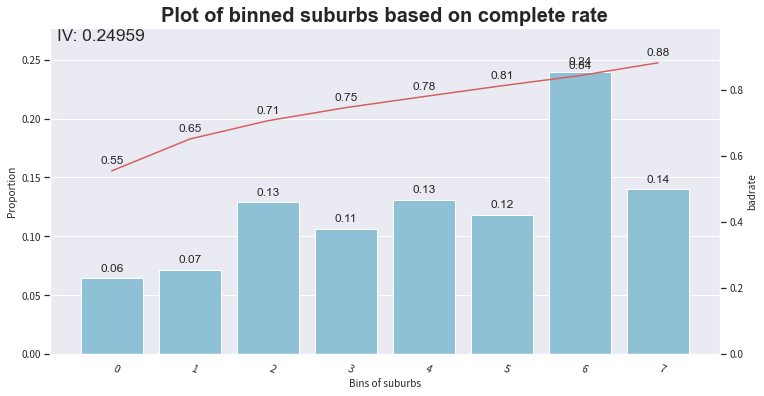

In [18]:
ax = bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned suburbs based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of suburbs")
ax.set_ylabel("Proportion")
#visualize the binning result

Text(0, 0.5, 'Proportion')

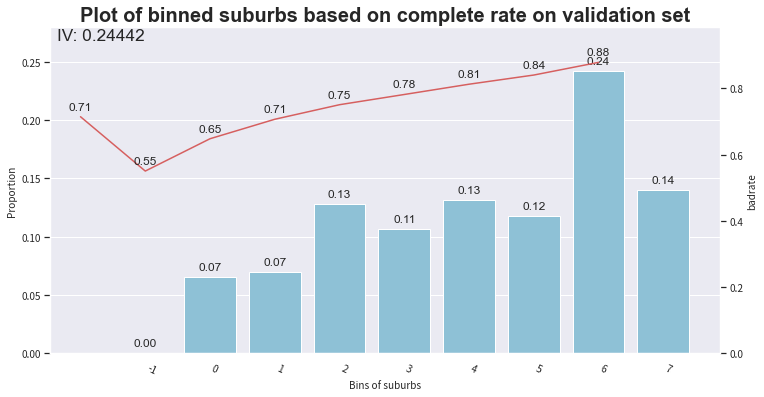

In [20]:
ax = bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned suburbs based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of suburbs")
ax.set_ylabel("Proportion")
#visualize the binning result on validation set 

In [21]:
c.export()
#binning results

{'PuSuburb': [['Bathurst',
   'Lithgow',
   'Brownlow Hill',
   'South Maroota',
   'Pitt Town',
   'Clarendon',
   'Lansdowne',
   'Windsor',
   'Hobartville',
   'Wollongong',
   'Bowenfels',
   'Glenmore',
   'South Windsor',
   'Audley',
   'Douglas Park',
   'Warrimoo',
   'Balmoral (South)',
   'Gosford',
   'Scotland Island',
   'Ku-Ring-Gai Chase',
   'Ebenezer',
   'Londonderry',
   'Cottage Point',
   'Wilton',
   'Oakdale',
   'Berkshire Park',
   'Cattai',
   'Palm Beach',
   'Whale Beach',
   'Springwood',
   'Oakville',
   'Mulgrave',
   'Mcgraths Hill',
   'Shanes Park',
   'The Oaks',
   'Port Kembla',
   'REGENTS PARK',
   'Sun Valley',
   'Werombi',
   'Lakesland',
   'Kelso',
   'Hill Top (North)',
   'HAYMARKET',
   'Belimbla Park',
   'Kurmond',
   'Vineyard',
   'Bligh Park',
   'Mount Vernon',
   'Agnes Banks',
   'Winmalee',
   'Windsor Downs',
   'Castlereagh',
   'Shalvey',
   'Bringelly',
   'WEST HOXTON',
   'Bilgola Beach',
   'Thirroul',
   'Wallerawang',


In [22]:
def PuSuburbBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'PuSuburb'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05) 
        data['PuSuburbBins_'+val] = c.transform(data[['PuSuburb']], labels=False) # 纯分箱不做woe转化
        data_test['PuSuburbBins_'+val] = c.transform(data_test[['PuSuburb']], labels=False)
    return data, data_test

data, validation = PuSuburbBins(data, validation)
#apply binning for all four target variables on both training and validation set and create four new features based on binning

In [29]:
data[['BookingID','PuSuburb','PuSuburbBins_Cancelled','PuSuburbBins_Completed','PuSuburbBins_ELSE','PuSuburbBins_NoJob']].head()
#binning result in dataset

,BookingID,PuSuburb,PuSuburbBins_Cancelled,PuSuburbBins_Completed,PuSuburbBins_ELSE,PuSuburbBins_NoJob
0,171970588,Randwick,0,6,0,3
1,174526964,Narraweena,4,3,1,3
2,180286324,Bondi,2,5,0,2
3,177228281,Centennial Park,2,5,0,3
4,170046024,Sydney,6,0,1,6


In [24]:
toad.quality(data[['PuSuburbBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')
#check iv value for cancelled

,iv,gini,entropy,unique
PuSuburbBins_Cancelled,0.249979,0.217016,0.369365,7.0


In [25]:
toad.quality(data[['PuSuburbBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')
#check iv value for else

,iv,gini,entropy,unique
PuSuburbBins_ELSE,0.216695,0.02451,0.065578,2.0


In [26]:
toad.quality(data[['PuSuburbBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')
#check iv value for nojob

,iv,gini,entropy,unique
PuSuburbBins_NoJob,0.227563,0.149151,0.276917,8.0


In [27]:
#the iv value for each group is high

## 2.2 Pickup lattitude & longitude

In [30]:
knn = KNeighborsClassifier(n_neighbors = 101)

knn.fit(data[['PuLat','PuLong']],data['target_2cls_Completed'])

data['KNN_temp'] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]
#use knn method to model lat and long with target complete and save the probability 

In [31]:
c = toad.transform.Combiner()
col = 'KNN_temp'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad package to binning the probabilty to check if it can be used to predict complete 

Text(0, 0.5, 'Proportion')

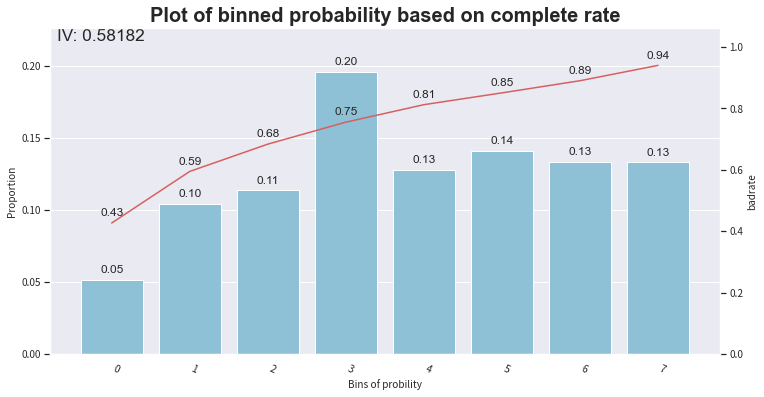

In [33]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned probability based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of probility")
ax.set_ylabel("Proportion")
#visualize the binning result to check the iv

Text(0, 0.5, 'Proportion')

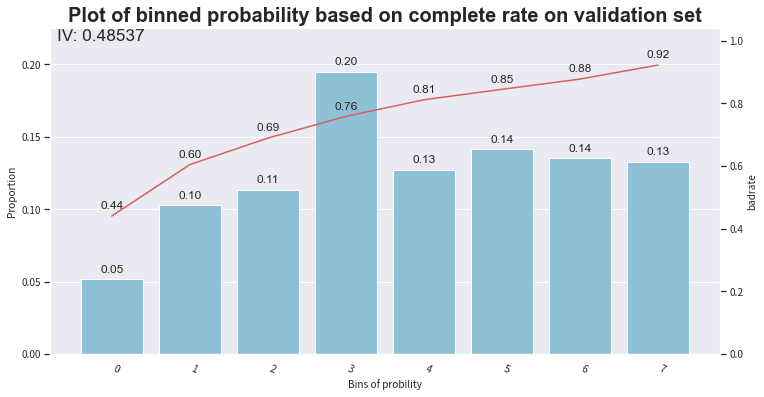

In [36]:
validation['KNN_temp'] = knn.predict_proba(validation[['PuLat','PuLong']])[:,1]
ax=bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned probability based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of probility")
ax.set_ylabel("Proportion")
#check on validation set also

In [39]:
def PuLatLongKNN(data, test):
    data = data.copy()
    test = test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        knn = KNeighborsClassifier(n_neighbors = 101)
        knn.fit(data[['PuLat','PuLong']],data[target])
        data['PuLatLongKNN_'+val] = knn.predict_proba(data[['PuLat','PuLong']])[:,1]
        test['PuLatLongKNN_'+val] = knn.predict_proba(test[['PuLat','PuLong']])[:,1]
    return data, test 

data,validation = PuLatLongKNN(data,validation)
#apply knn model to each target on both training and validation set and save probabilty, thus create four new features

In [46]:
toad.quality(data[['PuLatLongKNN_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')
#check iv value for cancelled

,iv,gini,entropy,unique
PuLatLongKNN_Cancelled,0.709143,0.212199,0.383407,91.0


In [42]:
toad.quality(data[['PuLatLongKNN_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')
#check iv value for else

,iv,gini,entropy,unique
PuLatLongKNN_ELSE,1.826409,0.024466,0.066926,35.0


In [43]:
toad.quality(data[['PuLatLongKNN_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')
#check iv value for no job

,iv,gini,entropy,unique
PuLatLongKNN_NoJob,0.761531,0.145988,0.285154,58.0


In [44]:
#they all have high iv, which means probabilty can be used to predict complete, cancelled, else and no job, it's a usefuk feature

In [47]:
data[['BookingID','PuLat','PuLong','PuLatLongKNN_Cancelled','PuLatLongKNN_Completed','PuLatLongKNN_ELSE','PuLatLongKNN_NoJob']].head()
#new features in training dataset

,BookingID,PuLat,PuLong,PuLatLongKNN_Cancelled,PuLatLongKNN_Completed,PuLatLongKNN_ELSE,PuLatLongKNN_NoJob
0,171970588,-33.921022,151.244202,0.049505,0.930693,0.009901,0.009901
1,174526964,-33.755931,151.273028,0.108911,0.801980,0.009901,0.079208
2,180286324,-33.897201,151.261205,0.089109,0.851485,0.000000,0.059406
3,177228281,-33.895716,151.228609,0.029703,0.930693,0.000000,0.039604
4,170046024,-33.859737,151.213307,0.366337,0.445545,0.029703,0.158416


## 2.3 Time

In [48]:
def OrderHour(data):
    data = data.copy()
    data['OrderHour'] = data['RequestedDate'].apply(lambda x: x.hour).astype(int)
    return data 
data = OrderHour(data)
validation= OrderHour(validation)
#transform hour to numerical data

In [49]:
c = toad.transform.Combiner()
col = 'OrderHour'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to binning hour based on complete rate

Text(0, 0.5, 'Proportion')

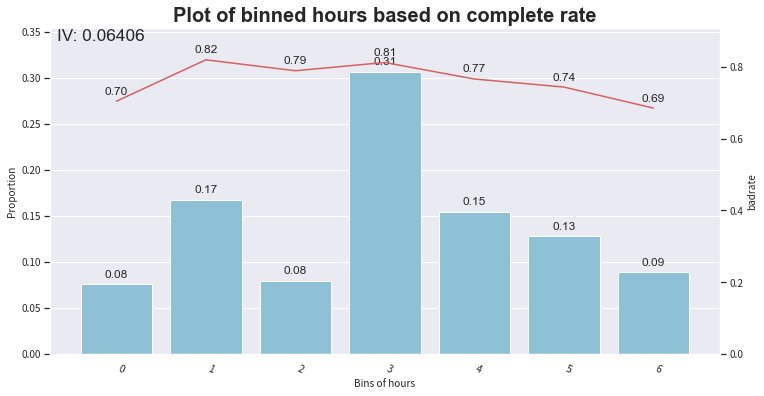

In [50]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned hours based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of hours")
ax.set_ylabel("Proportion")
#visualize the binning result

In [52]:
def DayOfWeek(data):
    data = data.copy()
    data['DayOfWeek'] = data['RequestedDate'].apply(lambda x: x.weekday()+1)
    return data
data = DayOfWeek(data)
validation = DayOfWeek(validation)
#transform day of week to numerical data

In [53]:
c = toad.transform.Combiner()
col = 'DayOfWeek'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to binning day of week

Text(0, 0.5, 'Proportion')

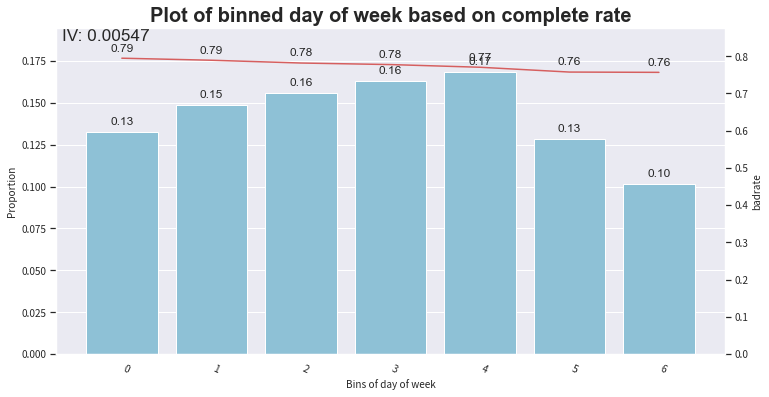

In [55]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned day of week based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day of week")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is quite low

In [57]:
dt = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
dt.fit(data[['DayOfWeek','OrderHour']] , data['target_2cls_Completed'])

def OrderTimeDT(data):
    data = data.copy()
    data['OrderTimeDT'] = dt.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
    return data 
#use decision tree classifier to model combined hour and day of week with complete rate and save the probability

In [58]:
data = OrderTimeDT(data)
validation = OrderTimeDT(validation)

In [59]:
c = toad.transform.Combiner()
col = 'OrderTimeDT'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use binning to to check whether ordertime dt is a good feature to predict target complete

Text(0, 0.5, 'Proportion')

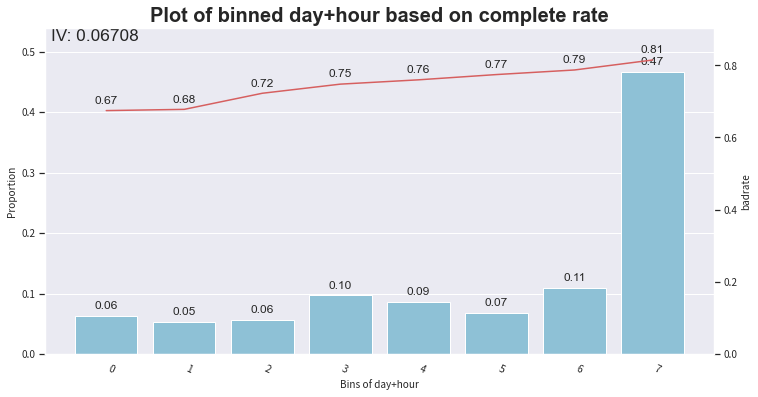

In [60]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned day+hour based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of day+hour")
ax.set_ylabel("Proportion")
#visualize the binning result, the iv is okay, so the probability is a reasonably good feature to predict complete

In [65]:
def OrderTimeDT(data, test):
    data = data.copy()
    test = test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        dt = DecisionTreeClassifier(max_depth = 4,min_samples_leaf=0.05)
        dt.fit(data[['DayOfWeek','OrderHour']] , data[target])
        data['OrderTimeDT_'+val] = dt.predict_proba(data[['DayOfWeek','OrderHour']])[:,1]
        test['OrderTimeDT_'+val] = dt.predict_proba(test[['DayOfWeek','OrderHour']])[:,1]
    return data, test 
data,validation = OrderTimeDT(data,validation)

In [66]:
toad.quality(data[['OrderTimeDT_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
OrderTimeDT_Cancelled,0.039493,0.223038,0.381403,8.0


In [67]:
toad.quality(data[['OrderTimeDT_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
OrderTimeDT_ELSE,0.020355,0.024582,0.06685,9.0


In [68]:
toad.quality(data[['OrderTimeDT_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
OrderTimeDT_NoJob,0.100457,0.150465,0.281428,7.0


In [ ]:
#check iv for rest of the target

In [70]:
data[['BookingID','OrderHour','DayOfWeek','OrderTimeDT_Cancelled','OrderTimeDT_Completed','OrderTimeDT_ELSE','OrderTimeDT_NoJob']].head()

,BookingID,OrderHour,DayOfWeek,OrderTimeDT_Cancelled,OrderTimeDT_Completed,OrderTimeDT_ELSE,OrderTimeDT_NoJob
0,171970588,11,4,0.103625,0.814538,0.013291,0.069492
1,174526964,9,7,0.103625,0.786954,0.012206,0.069492
2,180286324,0,7,0.157953,0.677855,0.017008,0.140237
3,177228281,9,4,0.103625,0.814538,0.012206,0.069492
4,170046024,21,4,0.177400,0.674436,0.013037,0.134820


## 2.4 Conditions

In [71]:
data['Conditions'] = data['Conditions'].astype(str)
validation['Conditions'] = validation['Conditions'].astype(str)
c = toad.transform.Combiner()
col = 'Conditions'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to bin the conditions based on complete rate

In [72]:
c.export()
#binning result

{'Conditions': [['4299161600',
   '138412032',
   '272629760',
   '137439215616',
   '274877916238',
   '4294983680',
   '554054975488',
   '275951648800',
   '274877906946',
   '274894684160',
   '275414777856',
   '17213423616',
   '554050781186',
   '17448304640',
   '17314086912',
   '17179869184',
   '12',
   '4299161604',
   '10',
   '549827117056',
   '68157440',
   '1048640',
   '16777248',
   '274877906948',
   '4456448',
   '4194306',
   '134234112',
   '138412036',
   '4194312',
   '103079215104',
   '274877908040',
   '279172874240',
   '134218752',
   '550028443648',
   '17183014912',
   '134217734',
   '32768',
   '549894225920',
   '274878955520',
   '536887296',
   '268435520',
   '824633720834',
   '4195330',
   '824633720832',
   '1572864',
   '554050781184',
   '549793562624',
   '34359738368',
   '275012124672',
   '134217792',
   '34359738432',
   '32',
   '274877906976',
   '20971520',
   '549890031616',
   '16386',
   '67108872',
   '268435456',
   '37748736',
  

Text(0, 0.5, 'Proportion')

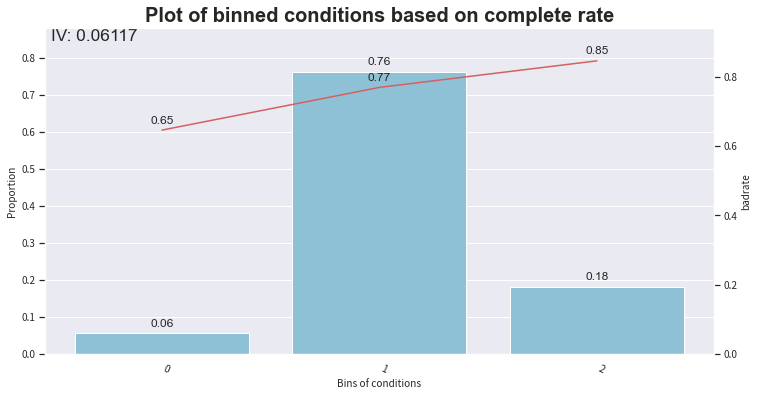

In [73]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned conditions based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize binning result and check iv

Text(0, 0.5, 'Proportion')

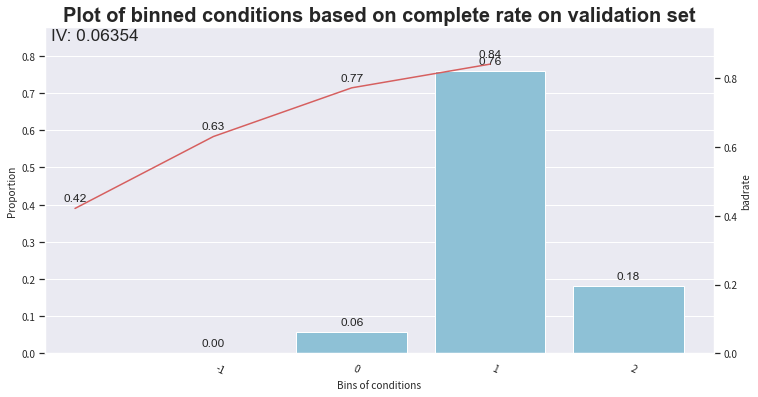

In [74]:
ax=bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned conditions based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize binning result on validation set and check iv

In [75]:
def ConditionsBins(data, test):
    data = data.copy()
    test = test.copy()
    data['Conditions'] = data['Conditions'].astype(str)
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'Conditions'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05)
        data['ConditionsBins_'+val] = c.transform(data[['Conditions']], labels=False)
        test['ConditionsBins_'+val] = c.transform(test[['Conditions']], labels=False)
    return data, test

data, validation = ConditionsBins(data, validation)
#apply binning to all four target variables 

In [78]:
data[['BookingID','Conditions','ConditionsBins_Cancelled','ConditionsBins_Completed','ConditionsBins_ELSE','ConditionsBins_NoJob']].head(20)

,BookingID,Conditions,ConditionsBins_Cancelled,ConditionsBins_Completed,ConditionsBins_ELSE,ConditionsBins_NoJob
0,171970588,0,0,1,0,3
1,174526964,0,0,1,0,3
2,180286324,0,0,1,0,3
3,177228281,0,0,1,0,3
4,170046024,0,0,1,0,3
5,174863088,0,0,1,0,3
6,169960932,0,0,1,0,3
7,171324643,0,0,1,0,3
8,174080542,524288,0,2,1,0
9,170182731,0,0,1,0,3


In [79]:
toad.quality(data[['ConditionsBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')
#check iv for cancelled

,iv,gini,entropy,unique
ConditionsBins_Cancelled,0.041767,0.222731,0.381125,2.0


In [80]:
toad.quality(data[['ConditionsBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')
#check iv for else

,iv,gini,entropy,unique
ConditionsBins_ELSE,0.346219,0.024435,0.064631,2.0


In [81]:
toad.quality(data[['ConditionsBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')
#check iv for nojob

,iv,gini,entropy,unique
ConditionsBins_NoJob,0.23399,0.150224,0.278627,4.0


## 2.5 Booking Fleet = Dispatch Fleet

In [82]:
equal = list()
for i in range(data.shape[0]):
    if data['BookingFleet'][i] == data['DispatchFleet'][i]:
        equal.append('True')
    else:
        equal.append('False')
#check whether booking fleet is the same as dispatch feet and create a new variable

In [83]:
equal2 = list()
for i in range(validation.shape[0]):
    if validation['BookingFleet'][i] == validation['DispatchFleet'][i]:
        equal2.append('True')
    else:
        equal2.append('False')
#same for validation set

In [84]:
data['BookingisDispatch'] = equal
validation['BookingisDispatch'] = equal2
#create new boolean variable 

## 2.6 Dispatch Fleet

In [86]:
c = toad.transform.Combiner()
col = 'DispatchFleet'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.01)
#use toad to bin dispatch fleet based on complete rate

In [87]:
c.export()

{'DispatchFleet': [['Training Sydney',
   'South Western Cabs',
   'iHail',
   'Sydney Tiger Team',
   '13cabs Wollongong',
   'WATs Sydney',
   'Blue Mountains 13cabs'],
  ['13cabs Sydney', 'Test Sydney'],
  ['Silver Service Sydney']]}

Text(0, 0.5, 'Proportion')

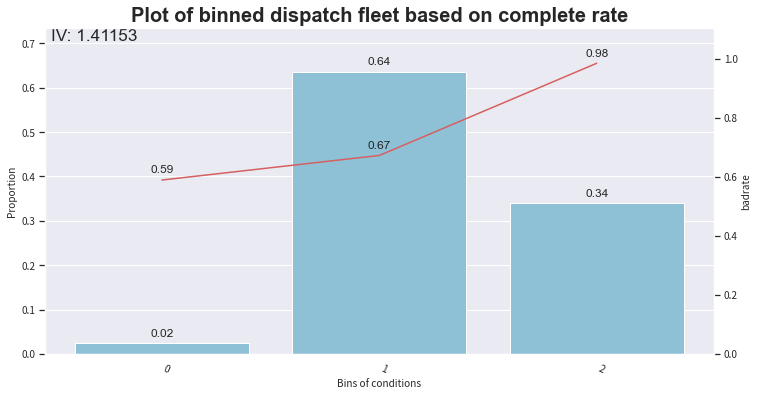

In [88]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned dispatch fleet based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv

Text(0, 0.5, 'Proportion')

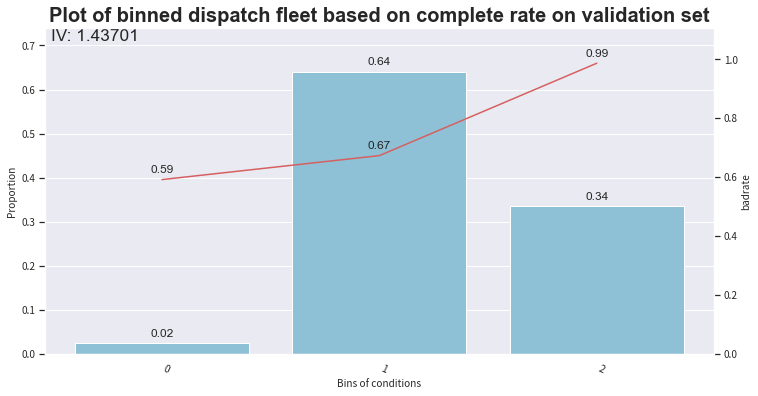

In [89]:
ax=bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned dispatch fleet based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize on validation set also

In [90]:
def DispatchFleetBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'DispatchFleet'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.01) 
        data['DispatchFleetBins_'+val] = c.transform(data[['DispatchFleet']], labels=False) 
        data_test['DispatchFleetBins_'+val] = c.transform(data_test[['DispatchFleet']], labels=False)
    return data, data_test

data,validation = DispatchFleetBins(data,validation)
#apply binning to all four target variables

In [93]:
data[['BookingID','DispatchFleet','DispatchFleetBins_Cancelled','DispatchFleetBins_Completed','DispatchFleetBins_ELSE','DispatchFleetBins_NoJob']].head(10)

,BookingID,DispatchFleet,DispatchFleetBins_Cancelled,DispatchFleetBins_Completed,DispatchFleetBins_ELSE,DispatchFleetBins_NoJob
0,171970588,13cabs Sydney,1,1,1,2
1,174526964,13cabs Sydney,1,1,1,2
2,180286324,13cabs Sydney,1,1,1,2
3,177228281,13cabs Sydney,1,1,1,2
4,170046024,13cabs Sydney,1,1,1,2
5,174863088,13cabs Sydney,1,1,1,2
6,169960932,Silver Service Sydney,0,2,0,0
7,171324643,Silver Service Sydney,0,2,0,0
8,174080542,13cabs Sydney,1,1,1,2
9,170182731,Silver Service Sydney,0,2,0,0


In [94]:
toad.quality(data[['DispatchFleetBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')
#check iv for cancelled

,iv,gini,entropy,unique
DispatchFleetBins_Cancelled,1.411809,0.208251,0.334045,3.0


In [95]:
toad.quality(data[['DispatchFleetBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')
#check iv for else

,iv,gini,entropy,unique
DispatchFleetBins_ELSE,1.077869,0.024048,0.060731,3.0


In [96]:
toad.quality(data[['DispatchFleetBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')
#check iv for nojob

,iv,gini,entropy,unique
DispatchFleetBins_NoJob,0.957894,0.145694,0.258893,3.0


## 2.7 Booking Fleet

In [58]:
#before_booking=data.to_csv('mid.csv')

In [68]:
#before_booking_val=validation.to_csv('midval.csv')

In [2]:
#data=pd.read_csv('mid.csv')

In [3]:
#validation=pd.read_csv('midval.csv')

In [4]:
#data = data.iloc[:,1:]

In [5]:
#validation = validation.iloc[:,1:]

In [97]:
data[['BookingFleet','target_2cls_Completed']].groupby('BookingFleet').agg(['mean','count']).\
sort_values(by=('target_2cls_Completed','mean'),ascending=True)

target_2cls_Completed         
                                       mean    count
BookingFleet                                        
Training Sydney                    0.002483     2416
iHail                              0.394737      304
Sydney Tiger Team                  0.466667       15
Blue Mountains 13cabs              0.654786    21352
Test Sydney                        0.708333       96
South Western Cabs                 0.719902      814
13cabs Sydney                      0.772805  2766068
WATs Sydney                        0.832917   118037
Silver Service Sydney              0.860334    90881
13cabs Wollongong                  0.941176       17

In [98]:
c = toad.transform.Combiner()
col = 'BookingFleet'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.001)
#use toad to bin booking fleet based on complete rate

In [99]:
c.export()#binning result

{'BookingFleet': [['Training Sydney',
   'iHail',
   'Sydney Tiger Team',
   'Blue Mountains 13cabs',
   'Test Sydney',
   'South Western Cabs'],
  ['13cabs Sydney'],
  ['WATs Sydney', 'Silver Service Sydney', '13cabs Wollongong']]}

Text(0, 0.5, 'Proportion')

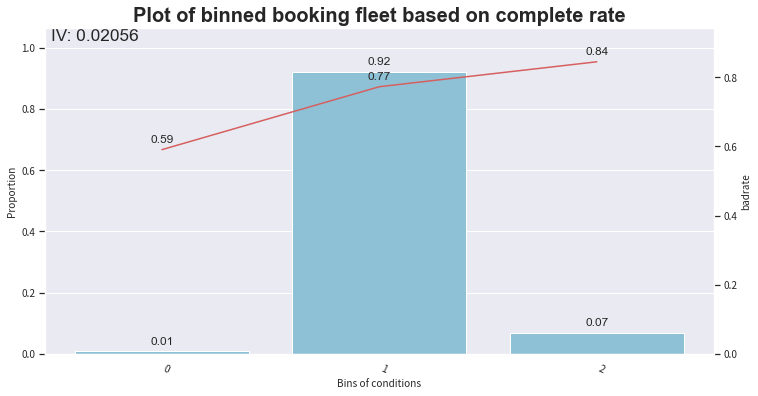

In [100]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned booking fleet based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv

Text(0, 0.5, 'Proportion')

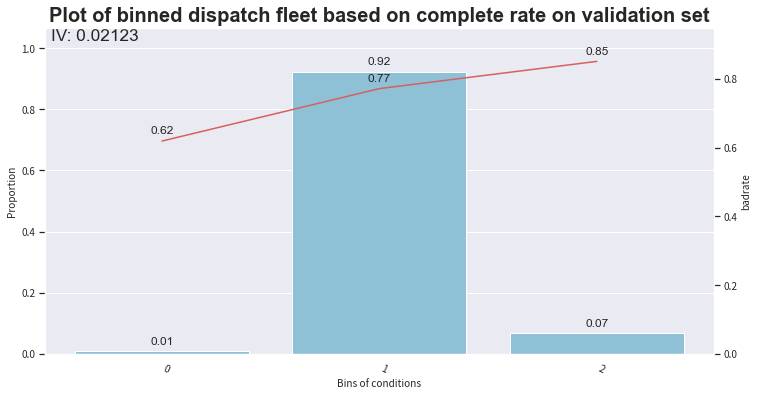

In [101]:
ax=bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned dispatch fleet based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result on validation set and check for iv

In [ ]:
#the iv is quite low which means booking fleet is not a good feature for predicting complete

In [102]:
def BookingFleetBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'BookingFleet'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.001) 
        data['BookingFleetBins_'+val] = c.transform(data[['BookingFleet']], labels=False) 
        data_test['BookingFleetBins_'+val] = c.transform(data_test[['BookingFleet']], labels=False)
    return data, data_test

data,validation = BookingFleetBins(data,validation)
#apply binning to all four target variables

In [103]:
toad.quality(data[['BookingFleetBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
BookingFleetBins_Cancelled,0.033075,0.223436,0.382003,4.0


In [104]:
toad.quality(data[['BookingFleetBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
BookingFleetBins_ELSE,0.254508,0.024455,0.065169,2.0


In [105]:
toad.quality(data[['DispatchFleetBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
DispatchFleetBins_NoJob,0.957894,0.145694,0.258893,3.0


In [106]:
#however, the iv for else and nojob is high, we can still use this feature 

In [107]:
data[['BookingID','BookingFleet','BookingFleetBins_Cancelled','BookingFleetBins_Completed','BookingFleetBins_ELSE','BookingFleetBins_NoJob']].head(10)

,BookingID,BookingFleet,BookingFleetBins_Cancelled,BookingFleetBins_Completed,BookingFleetBins_ELSE,BookingFleetBins_NoJob
0,171970588,13cabs Sydney,2,1,0,2
1,174526964,13cabs Sydney,2,1,0,2
2,180286324,13cabs Sydney,2,1,0,2
3,177228281,13cabs Sydney,2,1,0,2
4,170046024,13cabs Sydney,2,1,0,2
5,174863088,13cabs Sydney,2,1,0,2
6,169960932,13cabs Sydney,2,1,0,2
7,171324643,Silver Service Sydney,0,2,1,1
8,174080542,WATs Sydney,1,2,1,0
9,170182731,13cabs Sydney,2,1,0,2


## 2.6 Booking Source

In [108]:
c = toad.transform.Combiner()
col = 'BookingSource'
c.fit(data[[col,'target_2cls_Completed']], y = 'target_2cls_Completed', method = 'chi',min_samples = 0.05)
#use toad to bin booking source based on complete rate

In [109]:
c.export()

{'BookingSource': [['Permanent', 'Internet'], ['TelOp'], ['StratumIVR']]}

Text(0, 0.5, 'Proportion')

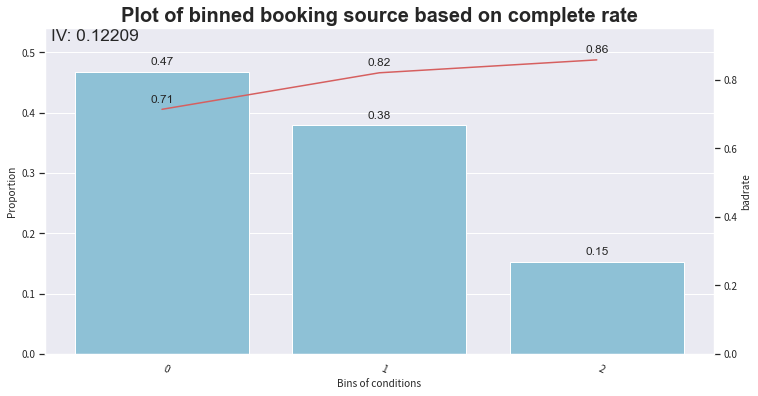

In [110]:
ax=bin_plot(c.transform(data[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed')
ax.set_title("Plot of binned booking source based on complete rate",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result and check for iv

Text(17.200000000000003, 0.5, 'Proportion')

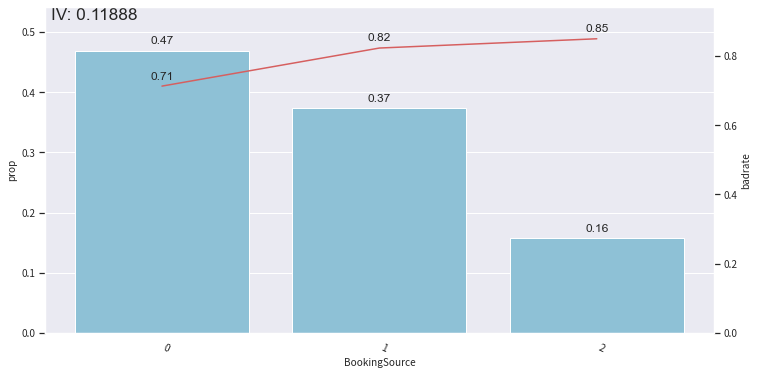

In [111]:
bin_plot(c.transform(validation[[col,'target_2cls_Completed']], labels=False), x=col, target='target_2cls_Completed') 
ax.set_title("Plot of binned booking source based on complete rate on validation set",fontweight='bold',fontsize=20)
ax.set_xlabel("Bins of conditions")
ax.set_ylabel("Proportion")
#visualize the binning result on validation set and check for iv

In [112]:
def BookingSourceBins(data,data_test):
    data = data.copy()
    data_test = data_test.copy()
    for target,val in zip(['target_2cls_Cancelled','target_2cls_Completed','target_2cls_ELSE','target_2cls_NoJob'],['Cancelled','Completed','ELSE','NoJob']):
        c = toad.transform.Combiner()
        col = 'BookingSource'
        c.fit(data[[col,target]], y = target, method = 'chi',min_samples = 0.05) 
        data['BookingSourceBins_'+val] = c.transform(data[['BookingSource']], labels=False) 
        data_test['BookingSourceBins_'+val] = c.transform(data_test[['BookingSource']], labels=False)
    return data, data_test

data,validation = BookingSourceBins(data,validation)
#apply binning to all four target variables

In [113]:
toad.quality(data[['BookingSourceBins_Cancelled','target_2cls_Cancelled']],target='target_2cls_Cancelled')

,iv,gini,entropy,unique
BookingSourceBins_Cancelled,0.460776,0.213501,0.359142,3.0


In [114]:
toad.quality(data[['BookingSourceBins_ELSE','target_2cls_ELSE']],target='target_2cls_ELSE')

,iv,gini,entropy,unique
BookingSourceBins_ELSE,0.765604,0.024374,0.062619,3.0


In [115]:
toad.quality(data[['BookingSourceBins_NoJob','target_2cls_NoJob']],target='target_2cls_NoJob')

,iv,gini,entropy,unique
BookingSourceBins_NoJob,0.009098,0.1516,0.284946,3.0


In [116]:
#the iv for most of them are high, it is a good feature

In [117]:
data[['BookingID','BookingSource','BookingSourceBins_Cancelled','BookingSourceBins_Completed','BookingSourceBins_ELSE','BookingSourceBins_NoJob']].head()

,BookingID,BookingSource,BookingSourceBins_Cancelled,BookingSourceBins_Completed,BookingSourceBins_ELSE,BookingSourceBins_NoJob
0,171970588,TelOp,1,1,2,1
1,174526964,TelOp,1,1,2,1
2,180286324,Internet,2,0,1,0
3,177228281,StratumIVR,0,2,0,2
4,170046024,Internet,2,0,1,0


## 2.7 Create dummy variables

In [118]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000000 entries, 0 to 2999999
Data columns (total 54 columns):
 #   Column                       Dtype         
---  ------                       -----         
 0   BookingID                    int64         
 1   BookingSource                object        
 2   Conditions                   object        
 3   HasCondition                 object        
 4   IsAccountBooking             object        
 5   CreatedDate                  datetime64[ns]
 6   RequestedDate                datetime64[ns]
 7   BookingFleet                 object        
 8   DispatchFleet                object        
 9   AreaNumber                   int64         
 10  PuPlace                      object        
 11  PuAddress                    object        
 12  PuSuburb                     object        
 13  PuLat                        float64       
 14  PuLong                       float64       
 15  TargetVariable               object        
 16  

In [119]:
data['HasCondition']=np.where(data['HasCondition'] == 'Yes',1,0)

In [120]:
validation['HasCondition']=np.where(validation['HasCondition'] == 'Yes',1,0)

In [121]:
data['IsAccountBooking']=np.where(data['IsAccountBooking'] == 'Yes',1,0)
validation['IsAccountBooking']=np.where(validation['IsAccountBooking'] == 'Yes',1,0)

In [122]:
data['BookingisDispatch']=np.where(data['BookingisDispatch'] == True,1,0)
validation['BookingisDispatch']=np.where(validation['BookingisDispatch'] == True,1,0)

In [126]:
#create dummy variables for rest of the categorical variables

In [127]:
final=data.to_csv('final.csv')

In [128]:
final_val=validation.to_csv('final_val.csv')

In [129]:
#save processed features

# 3. Model

In [131]:
train = pd.read_csv('final.csv')

In [132]:
validation = pd.read_csv('final_val.csv')

In [133]:
train = train.iloc[:,1:]

In [134]:
validation = validation.iloc[:,1:]

In [135]:
train.columns

Index(['BookingID', 'BookingSource', 'Conditions', 'HasCondition',
       'IsAccountBooking', 'CreatedDate', 'RequestedDate', 'BookingFleet',
       'DispatchFleet', 'AreaNumber', 'PuPlace', 'PuAddress', 'PuSuburb',
       'PuLat', 'PuLong', 'TargetVariable', 'target_2cls_Cancelled',
       'target_2cls_Completed', 'target_2cls_ELSE', 'target_2cls_NoJob',
       'target_4cls', 'PuSuburbBins_Cancelled', 'PuSuburbBins_Completed',
       'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob', 'KNN_temp',
       'PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 'OrderTimeDT',
       'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed', 'OrderTimeDT_ELSE',
       'OrderTimeDT_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'BookingisDispatch',
       'DispatchFleetBins_Cancelled', 'DispatchFleetBins_Completed',
       'DispatchFleetBins_ELSE', 'DispatchFl

In [136]:
mdl_cols = ['HasCondition','IsAccountBooking',  'PuSuburbBins_Cancelled', 'PuSuburbBins_Completed',
       'PuSuburbBins_ELSE', 'PuSuburbBins_NoJob','PuLatLongKNN_Cancelled', 'PuLatLongKNN_Completed', 'PuLatLongKNN_ELSE',
       'PuLatLongKNN_NoJob', 'OrderHour', 'DayOfWeek', 
       'OrderTimeDT_Cancelled', 'OrderTimeDT_Completed', 'OrderTimeDT_ELSE',
       'OrderTimeDT_NoJob', 'ConditionsBins_Cancelled',
       'ConditionsBins_Completed', 'ConditionsBins_ELSE',
       'ConditionsBins_NoJob', 'BookingisDispatch',
       'DispatchFleetBins_Cancelled', 'DispatchFleetBins_Completed',
       'DispatchFleetBins_ELSE', 'DispatchFleetBins_NoJob',
       'BookingFleetBins_Cancelled', 'BookingFleetBins_Completed',
       'BookingFleetBins_ELSE', 'BookingFleetBins_NoJob',
       'BookingSourceBins_Cancelled', 'BookingSourceBins_Completed',
       'BookingSourceBins_ELSE', 'BookingSourceBins_NoJob']

## 3.1 Logistic Regression-multinomial

In [55]:
#use multinomial to build the model
logit = LogisticRegression(multi_class = 'multinomial',solver = 'lbfgs',max_iter=10000)
logit.fit(train[mdl_cols],train['target_4cls'])


LogisticRegression(max_iter=10000, multi_class='multinomial')

In [56]:
logit.predict_proba(validation[mdl_cols])

array([[5.28482996e-02, 7.94263367e-01, 1.50833827e-01, 2.05450674e-03],
       [1.79960483e-01, 7.62046921e-01, 5.42583690e-02, 3.73422712e-03],
       [8.29085807e-05, 9.99717246e-01, 1.94459488e-04, 5.38635234e-06],
       ...,
       [6.60516910e-02, 8.62477132e-01, 6.75843423e-02, 3.88683524e-03],
       [5.34502885e-05, 9.99761188e-01, 1.80767377e-04, 4.59415042e-06],
       [4.25016624e-01, 3.89610332e-01, 8.95877115e-02, 9.57853324e-02]])

In [57]:
print('Training accuracy: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_4cls']))
print('validation accuracy: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_4cls']))
print('Training f1_score: ', f1_score(logit.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('validation f1_score: ', f1_score(logit.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.796623
validation accuracy:  0.7964966666666666
Training f1_score:  0.3780155240372233
validation f1_score:  0.37169026265638155


In [58]:
#对于complete的准确率较高，其他很低
print('Training accuracy of cancelled: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_Cancelled']))
print('Training accuracy of completed: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_Completed']))
print('Training accuracy of ELSE: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_ELSE']))
print('Training accuracy of No Job: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_2cls_NoJob']))

Training accuracy of cancelled:  0.11667933333333333
Training accuracy of completed:  0.7991076666666667
Training accuracy of ELSE:  0.06815833333333333
Training accuracy of No Job:  0.12262


In [59]:
logit_proba = pd.DataFrame(data = logit.predict_proba(validation[mdl_cols]), columns = ['Cancelled','Completed','ELSE','NoJob'])
logit_proba.corr()

# 输入4个预测概率之间的 Pearson correlation，看之间的概率是否有相关性；
# completed和cancelled有明显的负相关，和else也是，Nojob较低

,Cancelled,Completed,ELSE,NoJob
Cancelled,1.000000,-0.891778,0.293560,0.152185
Completed,-0.891778,1.000000,-0.665105,-0.321358
ELSE,0.293560,-0.665105,1.000000,0.099803
NoJob,0.152185,-0.321358,0.099803,1.000000


# 3.2 Logistic regression-ovr

In [ ]:
#use ovr extention to build the model
logit_ovr = LogisticRegression(multi_class = 'ovr',max_iter=10000) # 'one_vs_rest'
logit_ovr.fit(train[mdl_cols],train['target_4cls'])

In [ ]:
print('Training accuracy: ', accuracy_score(logit.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(logit.predict(validation[mdl_cols]), validation['target_4cls']))
print('Training f1_score: ', f1_score(logit.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(logit.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))


## 3.2 Random Forest

In [60]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#跑不出来，可以试着跑下
rf = RandomForestClassifier()
cls = GridSearchCV(rf, {'n_estimators' : [50,200,500], 'max_depth' : [2,3]},cv=3) # min_samples_weight =0.05

In [ ]:
#同上
n = np.argmax(cls.cv_results_['mean_test_score'])
print(cls.cv_results_['params'][n])

rf = cls.best_estimator_ #保存最优的模型

In [61]:
rf = RandomForestClassifier(n_estimators=500, max_depth=2) # min_samples_split

rf.fit(train[mdl_cols],train['target_4cls'])

RandomForestClassifier(max_depth=2, n_estimators=500)

In [62]:
print('Training accuracy: ', accuracy_score(rf.predict(train[mdl_cols]), train['target_4cls']))
print('validation accuracy: ', accuracy_score(rf.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(rf.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('validation f1_score: ', f1_score(rf.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.7763063333333333
validation accuracy:  0.7755833333333333
Training f1_score:  0.21851702005603763
validation f1_score:  0.21840240296616134


## 3.3 XGBoost

In [63]:
xgb = xgboost.XGBClassifier(n_estimators = 500, max_depth = 2, min_samples_weight = 0.05)
xgb.fit(train[mdl_cols],train['target_4cls']) 

/Users/Crystal/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[22:07:42] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { min_samples_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[22:07:50] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=2,
              min_child_weight=1, min_samples_weight=0.05, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=None, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [64]:
print('Training accuracy: ', accuracy_score(xgb.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(xgb.predict(validation[mdl_cols]), validation['target_4cls']))
print('Training f1_score: ', f1_score(xgb.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(xgb.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.8010453333333334
Test accuracy:  0.8000166666666667
Training f1_score:  0.38269267605660573
Test f1_score:  0.37475828694234703


## 3.4 Naive Bayes

In [65]:
gnb = GaussianNB()
gnb.fit(train[mdl_cols], train['target_4cls'])

GaussianNB()

In [66]:
print('Training accuracy: ', accuracy_score(gnb.predict(train[mdl_cols]), train['target_4cls']))
print('Test accuracy: ', accuracy_score(gnb.predict(validation[mdl_cols]), validation['target_4cls']))

print('Training f1_score: ', f1_score(gnb.predict(train[mdl_cols]), train['target_4cls'], average = 'macro'))
print('Test f1_score: ', f1_score(gnb.predict(validation[mdl_cols]), validation['target_4cls'], average = 'macro'))

Training accuracy:  0.46772633333333336
Test accuracy:  0.46317
Training f1_score:  0.3387349518060806
Test f1_score:  0.3353384243400674


In [ ]:
#xgboost的accuracy最高 f1和logistic差不多